In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler
import numpy as np
import matplotlib.colors as mcolors
import torch.nn.functional as F

from torchvision.utils import make_grid

import random
import os
from itertools import product

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [48]:
# Die ersten beiden leaning Raten waren zu hoch, erste bei der letzen hat es funktioniert
# Wahrscheinlich ist das problem unabhängig von der Distance der Loss-function

batch_size: int = 32
#learning_rate: int = 0.001
#learning_rate: int = 0.0005
#learning_rate: int = 0.00001
learning_rate: int = 0.000005

#path_mnist_data: str = '/..Autoencoder/data'

device: str = "mps" if torch.backends.mps.is_available() else "cpu"
device: torch.device = torch.device(device)

In [3]:
#https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246

class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=20.0, verbose=0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        #for debugging
        self.verbose = verbose

    def forward(self, output1, output2, label):

        #euclidean_distance = torch.sqrt((output1 - output2) ** 2)
        
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        if self.verbose >= 1:
            print(f'distance between the two vektores {output1}-{output2}: {euclidean_distance}')
        #negativ_differenz = self.margin ** 2 - euclidean_distance ** 2
        #if self.verbose >= 1:
        #    print(negativ_differenz)


        bound_negativ_pair = torch.max(self.margin ** 2 - euclidean_distance, torch.tensor(0.0)) ** 2
        if self.verbose >= 1:
            print(f'bound negative pair:{bound_negativ_pair}')

       #https://dvl.in.tum.de/slides/adl4cv-ws20/2.Siamese.pdf 
        loss_contrastive = label * euclidean_distance ** 2 + (1 - label) * bound_negativ_pair
        if self.verbose >= 1:
            print(f'contrastive loss: {loss_contrastive}')    
        return loss_contrastive.mean()

In [6]:
class Siamese_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        super(Siamese_Dataset, self).__init__()

        '''
        Download mnist dataset and transoform data to a tensor
        '''
        transform = transforms.Compose([transforms.ToTensor()])
        cifar_dataset = datasets.CIFAR10(root='./CIFAR10/data', train=True, download=True, transform=transform)

        #Filtert die MNIST datensatz nach den gewüschten lables
        images_label_9 = list(filter(lambda x: x[1] == 9, cifar_dataset))
        #Extrahiere die Daten aus den gefilterten Ergenissen
        images_label_9 = [img[0] for img in images_label_9]

        images_label_0 = list(filter(lambda x: x[1] == 0, cifar_dataset))
        images_label_0 = [img[0] for img in images_label_0]

        # Anzahl der Bilder mit Label 0 und 9
        print(f"Anzahl der Bilder mit Label 0: {len(images_label_0)}")
        print(f"Anzahl der Bilder mit Label 9: {len(images_label_9)}")

        assert(len(images_label_9), len(images_label_0))

        percent_keept_data = 0.1
        number_keept_data = int(percent_keept_data * len(images_label_9))

        self.random_images_labeled_9 = random.sample(images_label_9, number_keept_data)
        self.random_images_labeled_0 = random.sample(images_label_0, number_keept_data)

        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 0: {len(self.random_images_labeled_0)}")
        print(f"Anzahl der zufällig ausgewählten Bilder mit Label 9: {len(self.random_images_labeled_9)}")

        # Finde die Daten, die nicht ausgewählt wurden
        self.remaining_images_label_9 = list(set(images_label_9) - set(self.random_images_labeled_9))
        self.remaining_images_label_0 = list(set(images_label_0) - set(self.random_images_labeled_0))

        data_0 = list(product(self.random_images_labeled_0, repeat=2))
        data_9 = list(product(self.random_images_labeled_9, repeat=2))
        print("Beispielausgaben der Daten (Label 0):")
        self.print_examples(2, data_0)
        self.print_examples(2, data_9)

        data_combined = list(product(self.random_images_labeled_0, self.random_images_labeled_9))
        print("Beispielausgaben der Daten (Label 0 und Label 9):")
        self.print_examples(2, data_combined)

        data_labeled_1 = [(pair, 1) for pair in data_0 + data_9]
        data_labeled_0 = [(pair, 0) for pair in data_combined]

        self.data = data_labeled_1 + data_labeled_0

    def __len__(self):
        #assert(len(self.filtered_images), len(self.filtered_labels))
        return len(self.data)
    
    def __getitem__(self, idx):
        (img1, img2), label = self.data[idx]
        return img1, img2, label
        #image = self.filtered_images[idx]
        #label = self.filtered_labels[idx]
        #return image, label

    def get_data_0_9(self):
        return self.random_images_labeled_0, self.random_images_labeled_9
    
    def get_unlabeld_data_0_9(self):
        return self.remaining_images_label_0, self.remaining_images_label_9
    
    def print_examples(self, number_iterations: int, data: list[tuple]):
        for i in range(number_iterations):
            img1, img2 = data[i]
            print(f"data: ({img1.size()}, {img2.size()})")
            # Konvertiere Tensor in NumPy-Array und transponiere die Achsen, um das Bild korrekt darzustellen
            img1_np = img1.numpy().transpose((1, 2, 0))
            img2_np = img2.numpy().transpose((1, 2, 0))
    
            # Erstelle subplot und zeige die beiden Bilder an
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img1_np.squeeze(), cmap='gray')
            axs[0].set_title('Image 1')
            axs[1].imshow(img2_np.squeeze(), cmap='gray')
            axs[1].set_title('Image 2')
            plt.show()

<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/t_/1myf3wns5278ht8dnkq95ln80000gn/T/ipykernel_20786/4290691678.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(images_label_9), len(images_label_0))


100.0%


Extracting ./CIFAR10/data/cifar-10-python.tar.gz to ./CIFAR10/data
Anzahl der Bilder mit Label 0: 5000
Anzahl der Bilder mit Label 9: 5000
Anzahl der zufällig ausgewählten Bilder mit Label 0: 500
Anzahl der zufällig ausgewählten Bilder mit Label 9: 500
Beispielausgaben der Daten (Label 0):
data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


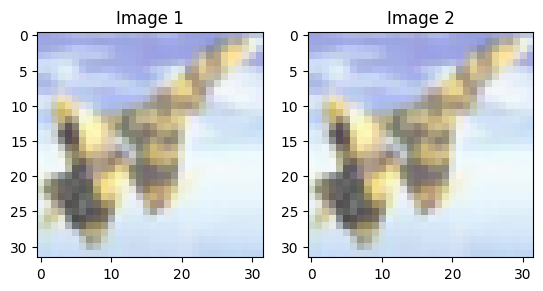

data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


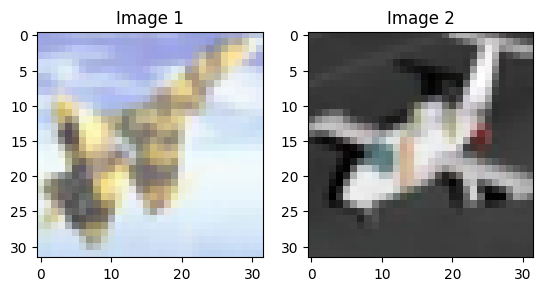

data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


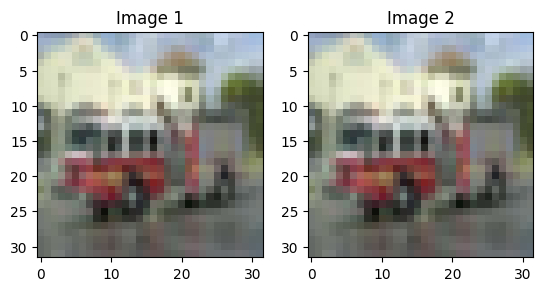

data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


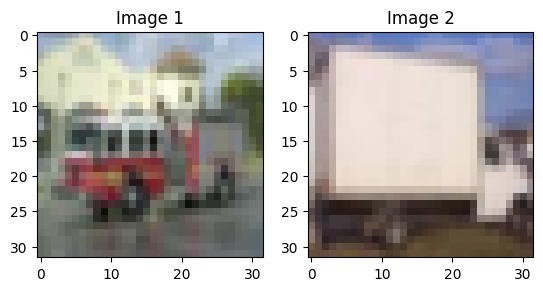

Beispielausgaben der Daten (Label 0 und Label 9):
data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


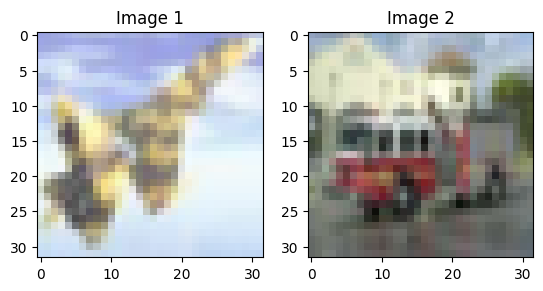

data: (torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))


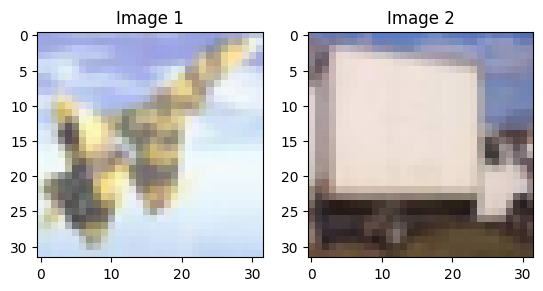

In [7]:
dataset_09 = Siamese_Dataset()
loader_09 = DataLoader(
    dataset = dataset_09,
    batch_size = batch_size,
    shuffle=True,
)

In [8]:
print('Training Set:\n')
for image1, image2, labels in loader_09:
    print('Image batch dimensions:', image1.size())
    print('Image batch dimensions:', image2.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([32, 3, 32, 32])
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


In [49]:
# Siamese network mit nur einen pfard
# Der zweite pfard wird erstellt, indem das model einfach nochmal durchlaufen wird im training

# Es besteht auch die Möglichkeit beide durchläufe in einem netz zu machen

class Seamese_network(nn.Module):
    def __init__(self) -> None:
        super(Seamese_network, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(5, 5))
            #nn.LeakyReLU(negative_slope=0.1),
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 5))
            #nn.LeakyReLU(negative_slope=0.1),
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(16 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 32)
    
    """
    Mit der leaky relu Aktivierungsfunktion(negative slope= 0.1) explodiert die loss:
    ----------------Start trainign Epoche 0----------------
    Epoche: 0 Average Loss: 31.96145576324463
    ----------------Start trainign Epoche 1----------------
    Epoche: 1 Average Loss: 5036.7331955078125
    ----------------Start trainign Epoche 2----------------
    Epoche: 2 Average Loss: 168627.32698125
    ----------------Start trainign Epoche 3----------------
    Epoche: 3 Average Loss: 1005168.5827666667

    Bei der normalen relu -> function lernt der algorithmus
    """


    # hängt sich auf bei 2.0866666
    def forward_once(self, x) -> torch.Tensor:
        x = self.conv1(x)
        #x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.max_pool1(x)
        x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.conv2(x)
        #x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = self.max_pool2(x)
        x = F.relu(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        #x = F.leaky_relu(x, negative_slope=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x, y) -> torch.Tensor:
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)
        return out1, out2
        

network: Seamese_network = Seamese_network().to(device)
print(network)

Seamese_network(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
)


In [50]:
print(f'Output Size der einzelnen layern im Encoder')
input_tensor_network = torch.randn(64, 3, 32, 32).to(device)
with torch.no_grad():
    output = input_tensor_network
    for name, layer in network.named_children():
        if name == "fc1":
            output = output.view(-1, 16 * 5 * 5)
        output = layer(output)
        print(f"{name}: {output.size()}")

Output Size der einzelnen layern im Encoder
conv1: torch.Size([64, 8, 28, 28])
max_pool1: torch.Size([64, 8, 14, 14])
conv2: torch.Size([64, 16, 10, 10])
max_pool2: torch.Size([64, 16, 5, 5])
fc1: torch.Size([64, 64])
fc2: torch.Size([64, 32])


In [51]:
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

loss_func = ContrastiveLoss(margin=10.0)

data0, data9 = dataset_09.get_unlabeld_data_0_9()

list_latend_space = []
list_epoch_loss = [] 
loss_iteration = []
for epoch in range(20):
    print(f'----------------Start trainign Epoche {epoch}----------------')
    epoch_loss: float = 0.0
    epoch_latends = []
    epoch_labels = []
    for (images_1, images_2, targets) in loader_09:
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

        output1, output2 = network(images_1, images_2)
        #output2 = network(images_2)
        #atend_space = encoder_model(inputs)
        #outputs = decoder_model(latend_space)
        loss = loss_func(output1, output2, targets)
        loss.backward()
        optimizer.step()
        iteration_loss = loss.item()
        loss_iteration.append(iteration_loss)
        #epoch_loss += loss.item()
        epoch_loss += loss.item()
        #del images_1, images_2, output1, output2, loss
        #epoch_latends.append(output1)
        #epoch_latends.append(output2) 

    list_epoch_loss.append(epoch_loss/len(loader_09))

    for x,y in zip(data0, data9):
        x, y = x.to(device), y.to(device)
        output1, output2 = network(x, y)
        epoch_latends.append(output1)
        epoch_labels.append(0)
        epoch_latends.append(output2)
        epoch_labels.append(9)
    embedes = epoch_latends#.to("cpu").detach().numpy()
    embedes_lables = epoch_labels#.to("cpu").detach().numpy()
    #------------ print latend umd zu sehen was passiert---------
    #tnse = TSNE(n_components=2, random_state=42)
    #features_2d = tnse.fit_transform(embedes)

    #plt.figure(figsize=(10,7))
    #scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embedes_lables, cmap='viridis', alpha=0.6)
    #plt.colorbar(scatter)
    #plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
    #plt.xlabel('t-SNE Dimension 1')
    #plt.ylabel('t-SNE Dimension 2')
    #plt.show()
    #-------------- ende des prints ------------------------
    tupel = (epoch_latends, epoch_labels)
    list_latend_space.append(tupel)
    print(f'Epoche: {epoch} Average Loss: {epoch_loss/len(loader_09)}')

----------------Start trainign Epoche 0----------------
Epoche: 0 Average Loss: 2102.386655683637
----------------Start trainign Epoche 1----------------
Epoche: 1 Average Loss: 1448.7088153812094
----------------Start trainign Epoche 2----------------
Epoche: 2 Average Loss: 891.0127067054862
----------------Start trainign Epoche 3----------------
Epoche: 3 Average Loss: 390.79685759737646
----------------Start trainign Epoche 4----------------
Epoche: 4 Average Loss: 183.82905553727744
----------------Start trainign Epoche 5----------------
Epoche: 5 Average Loss: 126.60037608129984
----------------Start trainign Epoche 6----------------
Epoche: 6 Average Loss: 83.60858716776737
----------------Start trainign Epoche 7----------------
Epoche: 7 Average Loss: 69.00950316542986
----------------Start trainign Epoche 8----------------
Epoche: 8 Average Loss: 55.12140515750052
----------------Start trainign Epoche 9----------------
Epoche: 9 Average Loss: 51.604561093012435
---------------

In [52]:
# Zusammenfassen des latendspaces pro Epoche
latend_space_epoch: list((torch.Tensor, torch.Tensor)) = []
for i, (latend_spaces, labels) in enumerate(list_latend_space):
    embeded: torch.Tensor = latend_spaces[0] # First Embeded Tensor for each epoch
    embeded_labels: torch.Tensor = torch.tensor([labels[0]]) # First Label for each epoch
    if len(latend_spaces) != len(labels): # Check if len labels and epoch is simlar, if not something went wrong
        print("Fehler")
        break
    for i in range(1,len(latend_spaces)): # itereate over all training iterations per epoch
        embeded = torch.cat((embeded, latend_spaces[i]), 0)
        embeded_labels =  torch.cat((embeded_labels, torch.tensor([labels[i]])), 0)
    
    latend_space_epoch.append((embeded, embeded_labels)) # Write the combined embededs and labels per epoch to array

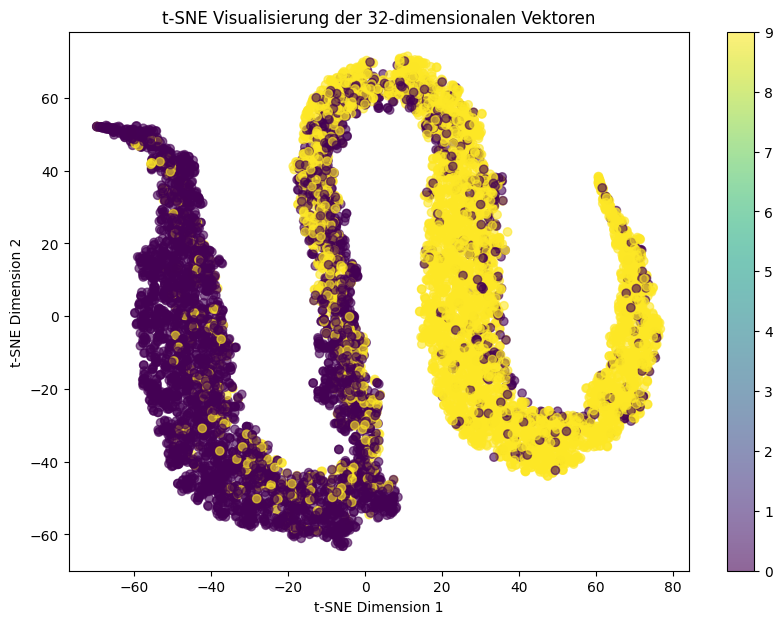

In [53]:
embeded = latend_space_epoch[9][0].to("cpu").detach().numpy()
embeded_label = latend_space_epoch[9][1].to("cpu").detach().numpy()

tnse = TSNE(n_components=2, random_state=42)

features_2d = tnse.fit_transform(embeded)

tnse = TSNE(n_components=2, random_state=42)
features_2d = tnse.fit_transform(embeded)

plt.figure(figsize=(10,7))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=embeded_label, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

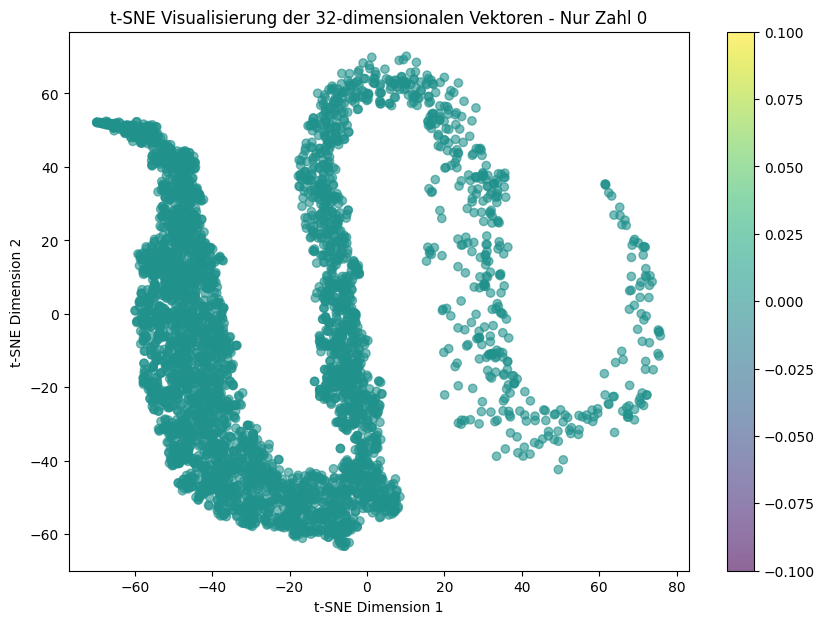

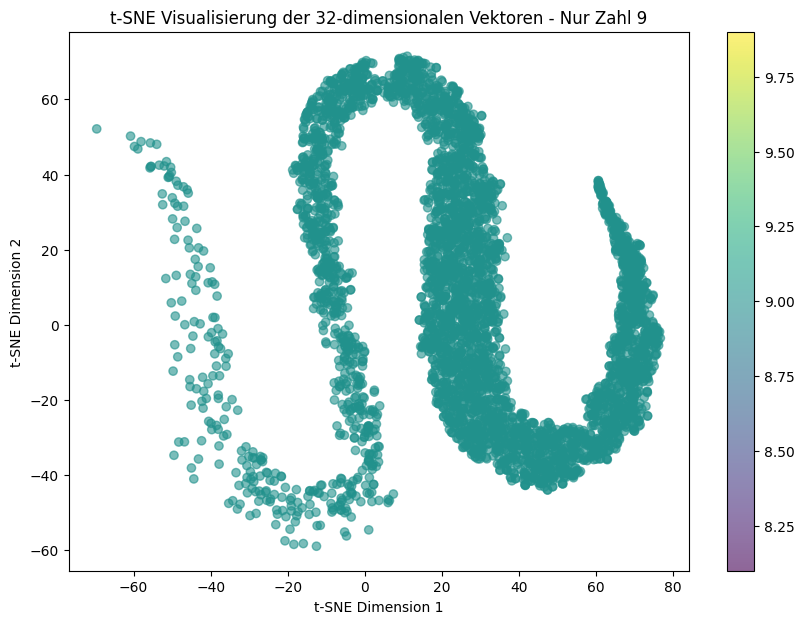

In [54]:
# Filtere die Daten für die Zahl 0
mask_0 = embeded_label == 0
features_2d_0_save = features_2d[mask_0]
labels_0 = embeded_label[mask_0]

# Filtere die Daten für die Zahl 9
mask_9 = embeded_label == 9
features_2d_9_save = features_2d[mask_9]
labels_9 = embeded_label[mask_9]

# Erstelle den Scatter-Plot für die Zahl 0
plt.figure(figsize=(10, 7))
scatter_0 = plt.scatter(features_2d_0_save[:, 0], features_2d_0_save[:, 1], c=labels_0, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_0)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 0')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Optional: Erstelle den Scatter-Plot für die Zahl 9
plt.figure(figsize=(10, 7))
scatter_9 = plt.scatter(features_2d_9_save[:, 0], features_2d_9_save[:, 1], c=labels_9, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_9)
plt.title('t-SNE Visualisierung der 32-dimensionalen Vektoren - Nur Zahl 9')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()